# Diabetes Prediction - Bayesian Network

Rebecca Hadi <br>
Probabilistic Graphic Models 625.692 <br>
Johns Hopkins Whiting School of Engineering

# Table of Contents <br>
1. Imports and Helper Functions <br>
2. Data Inspection and Prepartion <br>
2a. Zero Value Features <br> 
2a.i. Impute based on distribution <br>
2b. Exploration of Features <br>
2c. Discretize Features <br> 
2d. Training & Test Split <br>
3. Bayesian Network <br>
3a. Construct Networks <br>
3b. Plot Bayesian Networks <br>
3c. Bayesian Network Training and Evaluation <br>
3d. Explore Conditional Probability Distributions and Node Cardinality <br>
4. Naive Bayes <br> 
5. Bayesian Inference <br>
5a. Variable Elimination (Naive Bayes) <br>
5b. Variable Elimination (Best Performing Bayes Net: Outcome Hierarchical Model)
6. Markov Network <br> 
6a. Construct the Markov Network <br>
6b. Convert to a Bayesian Model <br>
6c. Create Junction Tree <br>
7. Inference using Belief Propagation <br>
8. Markov Chain Monte Carlo (MCMC) <br>
8a. Logistic Regression (for MCMC) <br>
8b. Initial Values for MCMC will be from Logistic Regression Model <br>

In [116]:
results_dict

{'No Dependency Model-normal-test': (0.639457256805965, 0.31111111111111106),
 'No Dependency Model-normal-train': (0.9992502624081572, 0.9736842105263158),
 'No Dependency Model-over-test': (0.6485470085470086, 0.2826086956521739),
 'No Dependency Model-over-train': (0.9995056449432125, 0.9869375907111756),
 'Hierarchical Model-normal-test': (0.6695994637171108, 0.5508982035928144),
 'Hierarchical Model-normal-train': (0.9419990899438798, 0.7968337730870712),
 'Hierarchical Model-over-test': (0.6865027678280691, 0.5930232558139534),
 'Hierarchical Model-over-train': (0.9486941503099173, 0.8765603328710124),
 'Outcome Hierarchical Model-normal-test': (0.6208898239052517,
  0.5207100591715976),
 'Outcome Hierarchical Model-normal-train': (0.9777190213101814,
  0.8587257617728532),
 'Outcome Hierarchical Model-over-test': (0.6355762824783477,
  0.5568181818181818),
 'Outcome Hierarchical Model-over-train': (0.9756861870788743,
  0.9150684931506848),
 'Pregnancy Hierarchical Model-normal-

# 1. Imports and Helper Functions

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import pgmpy 
from scipy.stats import ttest_ind
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import pylab as plt
import sklearn
from sklearn.model_selection import train_test_split
import pgmpy
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from pgmpy.metrics import log_likelihood_score
from pgmpy.models import NaiveBayes
from pgmpy.models import JunctionTree
from pgmpy.inference import VariableElimination
from pgmpy.models import MarkovNetwork
from pgmpy.inference import BeliefPropagation
from sklearn.linear_model import LogisticRegression
import scipy
import statsmodels.api as sm 

#### Helper Functions

In [2]:
def compare_features(df, response, feature, bins, save_fig):
    '''
    for a continuous feature, compare the distribution between the positive and negative classes 
    returns a plot and results of t-test for statistical significance
    '''
    # filter out nulls and filter on class 
    positive_class = df[df[response] ==1][feature]
    negative_class = df[df[response] ==0][feature]
    
    # filter out nulls
    positive_class = positive_class[positive_class.isna() == False]
    negative_class = negative_class[negative_class.isna() == False]

    # histogram 
    plt.subplots(tight_layout=True)
    plt.hist(positive_class, bins, alpha=0.5, label='positive_class')
    plt.hist(negative_class, bins, alpha=0.5, label='negative_class')
    plt.legend(loc='upper right')
    plt.title(f"Comparison of {feature} for {response}")

    if save_fig == 1: 
        plt.savefig(f'project/project-results/histogram-comparing-{feature}-by{response}',format = 'png')
    else: 
        pass 
    plt.show()
    
    # t test 
    results = ttest_ind(positive_class, negative_class)
    print(f"{feature}\n {results}")
    if results[1] < 0.05: 
        print("Difference is statistically significant at alpha = 0.05")
    else: 
        print("Result is not statistically significant at alpha = 0.05")

In [3]:
def plot_network(model, model_name):
    '''Function used to plot Bayesian Networks'''
    pos = nx.shell_layout(model)
    nx.draw(model, node_color='#00b4d9', pos=pos, with_labels=True) 
    plt.title(f"Bayesian Network Model: {model_name}")
    plt.savefig(f"figs/{model_name}_network.png")
    plt.show()

In [16]:
def split_and_sample(df, continuous_features):
    '''Input df, get back train test split and also over sampled train'''
    X_train, X_test, y_train, y_test = train_test_split(df[continuous_features], df['Outcome'], test_size = 0.3)
    oversample = RandomOverSampler(sampling_strategy='minority')
    X_over, y_over = oversample.fit_resample(X_train, y_train) # set to be used in model training 
    return X_train, X_over, X_test,  y_train, y_over, y_test

In [7]:
def fit_model(X,y, model_name, model):
    y_df = pd.DataFrame(y, columns=['Outcome'])
    df_temp = pd.concat([X, y_df],axis=1)
    if model_name == 'Naive Bayes':
        model.fit(df_temp,'Outcome')
    else:
        model.fit(df_temp)
    return model

In [56]:
def evaluate_model(X, y, model):
    y_prob = model.predict_probability(X)['Outcome_1']
    y_pred = model.predict(X)
    roc_score = roc_auc_score(y, y_prob)
    f1_score_ = f1_score(y, y_pred, zero_division=1)
    return roc_score, f1_score_

In [41]:
def train_test_network(df, results_dict, continuous_features, model, model_name, sample_type):
    '''
    Input data frame, features, model, and model name. 
    Get back ROC-AUC, F1 scores for sampled and over sampled data
    '''
    print("Splitting Data")
    X_train, X_over, X_test, y_train, y_over, y_test = split_and_sample(df, continuous_features)
    
    
    if sample_type == 'normal':
        print("Fitting Model")
        model = fit_model(X_train, y_train, model_name, model)
        print("Evaluating test")
        roc_score, f1_score_ = evaluate_model(X_test, y_test, model)
        print("Evaluating train")
        roc_score_train, f1_score_train = evaluate_model(X_train, y_train, model)
    
    elif sample_type == 'over':
        print("Fitting Model")
        model = fit_model(X_over, y_over, model_name, model)
        print("Evaluating test")
        roc_score, f1_score_ = evaluate_model(X_test, y_test, model)
        print("Evaluating train")
        roc_score_train, f1_score_train = evaluate_model(X_over, y_over, model)

    print("Add Results to dict")

    results_dict[model_name+'-'+sample_type+'-test'] = (roc_score,f1_score_)
    results_dict[model_name+'-'+sample_type+'-train'] = (roc_score_train,f1_score_train)

    print(f'''
    {model_name}: {sample_type} \n 
    Train: \n
    ROC: {roc_score_train}  F1: {f1_score_train}
    Test: 
    ROC: {roc_score}  F1: {f1_score_}
    ''')



In [92]:
def estimate_posterior(model, evidence):
    infer = VariableElimination(model)
    posterior_p = infer.query(["Outcome"], evidence=evidence)
    print(posterior_p)

In [105]:
def plot_network_markov(model, model_name):
    pos = nx.shell_layout(model)
    nx.draw(model, node_color='#00b4d9', pos=pos, with_labels=True) 
    plt.title(f"Markov Network Model: {model_name}")
    plt.savefig(f"figs/{model_name}_network.png")
    plt.show()

In [30]:
def plot_samples(samples):
    plt.subplot(211)
    plt.hist(samples, histtype='stepfilled', 
    color = 'darkred', bins=30, alpha=0.8, density=True);
    plt.ylabel('Probability Density')
    plt.show()

In [17]:
# Logistic function
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

## 2. Data Inspection and Preparation 

The data for this project is the "PIMA Indians Diabetes" prediction data set, found via Kaggle. Full citation of the data set is in the accompanying paper. This data set is limited to females who are above 21, and therefore are not representative of the general population. 

In [4]:
df = pd.read_csv('diabetes.csv')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


There are no misisng values, so we do not need to test for MCAR or MAR. 

In [11]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 2a. Zero Value Features 

In [5]:
zero_value_features = ['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

It is reasonable for the variable `Pregnancy` to have 0 value - we would not expect all females in the data set to have had at least 1 child. However, the values for `Glucose`, `BloodPresure`, `SkinThickness`, `Insulin` and `BMI`, we would not expect 0 values (e.g. you cannot have 0 blood pressure while living.We will now check for the prevalence of zero values by feature. The zero values could be from human error (did not write it down, or instrument error (e.g. broken collection instrument))) 

In [6]:
for feature in zero_value_features: 
    print(f"{feature}: Zero Values {df[feature].loc[df[feature] == 0].count()}")

Glucose: Zero Values 5
BloodPressure: Zero Values 35
SkinThickness: Zero Values 227
Insulin: Zero Values 374
BMI: Zero Values 11


Because there are not the same number of zero values for each feature, we cannot assume Missing Completely at Random. As a result, we should impute values assuming they are sampled from a distribution. 

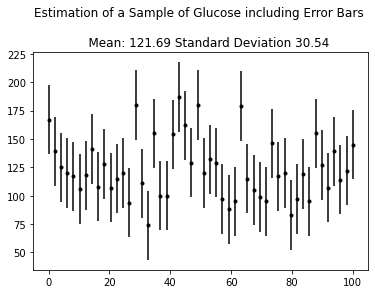

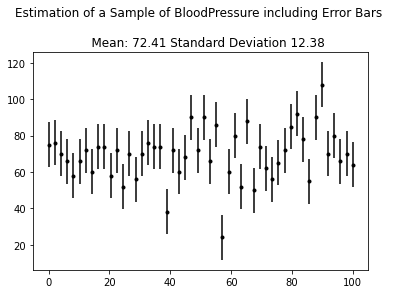

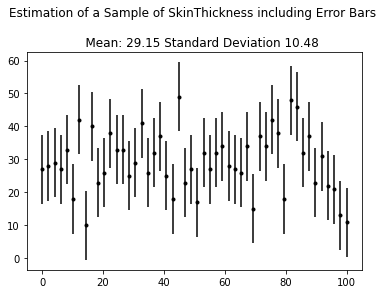

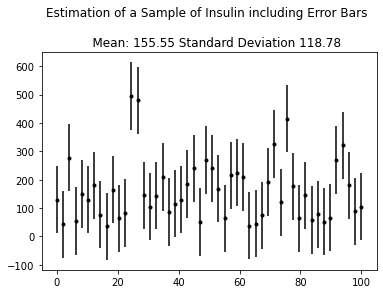

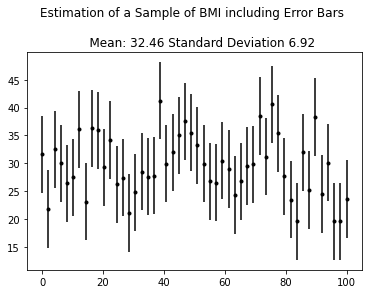

In [7]:
feature_dict = {}
for feature in zero_value_features: 
    y = df[feature].loc[df[feature] > 0]
    mean_y = y.mean()
    std_dev_y = y.std()
    y = np.random.choice(y, 50)
    x = np.linspace(0, 100, len(y))
    dy = std_dev_y
    feature_dict[feature] = (mean_y, dy)
    plt.errorbar(x, y, yerr=dy, fmt='.k');
    plt.title(f'''Estimation of a Sample of {feature} including Error Bars \n 
    Mean: {mean_y:.2f} Standard Deviation {dy:.2f}''')
    plt.show()

### 2a.i Impute based on distribution

We will now impute values for each of the zero value features assuming they are drawn from a Gaussian distribution with mean and standard deviation based on the zero value entries. 

In [48]:
feature_dict

{'Glucose': (121.6867627785059, 30.53564107280403),
 'BloodPressure': (72.40518417462484, 12.382158210105263),
 'SkinThickness': (29.153419593345657, 10.476982369987212),
 'Insulin': (155.5482233502538, 118.77585518724514),
 'BMI': (32.45746367239099, 6.924988332105907)}

In [8]:
for feature in zero_value_features:  
    len_y = len(df[feature].loc[df[feature] == 0])
    mean_y, std_dev_y = feature_dict[feature]
    print(f"{feature} Impute from Gaussian:  ({mean_y:.2f}, {std_dev_y:.2f})")
    index = df[feature].loc[df[feature] == 0].index
    value = np.random.normal(loc=mean_y, scale=std_dev_y, size=len_y)
    df.loc[index,feature] = value


Glucose Impute from Gaussian:  (121.69, 30.54)
BloodPressure Impute from Gaussian:  (72.41, 12.38)
SkinThickness Impute from Gaussian:  (29.15, 10.48)
Insulin Impute from Gaussian:  (155.55, 118.78)
BMI Impute from Gaussian:  (32.46, 6.92)


In [9]:
# test to validate imputation
for feature in zero_value_features: 
    print(f"{feature}: Zero Values {df[feature].loc[df[feature] == 0].count()}")

Glucose: Zero Values 0
BloodPressure: Zero Values 0
SkinThickness: Zero Values 0
Insulin: Zero Values 0
BMI: Zero Values 0


## 2b. Exploration of Features 

In [10]:
continuous_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

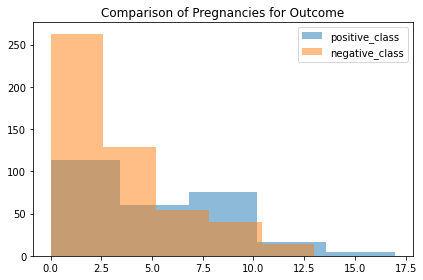

Pregnancies
 Ttest_indResult(statistic=6.298430550035151, pvalue=5.065127298053476e-10)
Difference is statistically significant at alpha = 0.05


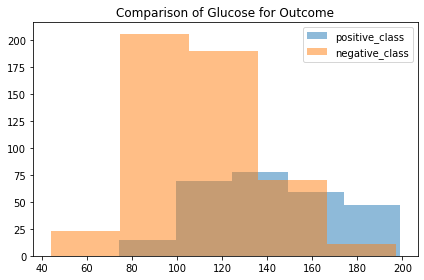

Glucose
 Ttest_indResult(statistic=15.492059001780484, pvalue=2.7104209741613357e-47)
Difference is statistically significant at alpha = 0.05


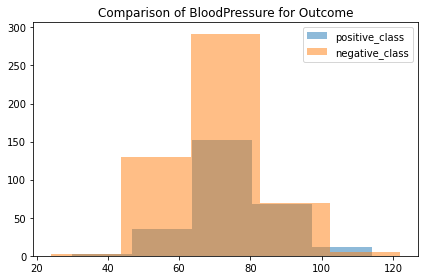

BloodPressure
 Ttest_indResult(statistic=4.617328171859136, pvalue=4.557656091454922e-06)
Difference is statistically significant at alpha = 0.05


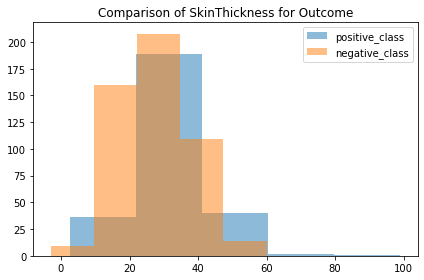

SkinThickness
 Ttest_indResult(statistic=5.8523141873383215, pvalue=7.184547225982003e-09)
Difference is statistically significant at alpha = 0.05


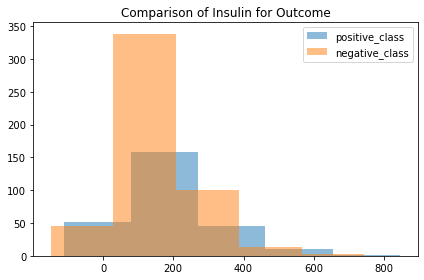

Insulin
 Ttest_indResult(statistic=4.177616480338424, pvalue=3.284933748537596e-05)
Difference is statistically significant at alpha = 0.05


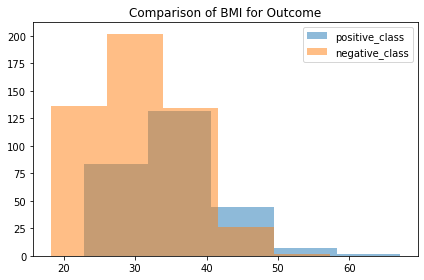

BMI
 Ttest_indResult(statistic=9.068126177006524, pvalue=1.000060903740437e-18)
Difference is statistically significant at alpha = 0.05


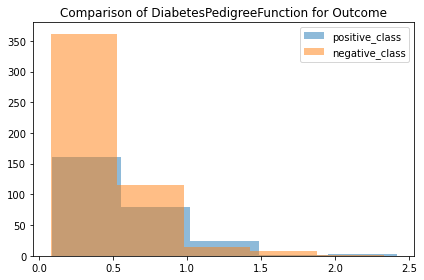

DiabetesPedigreeFunction
 Ttest_indResult(statistic=4.88582646072744, pvalue=1.254607010148809e-06)
Difference is statistically significant at alpha = 0.05


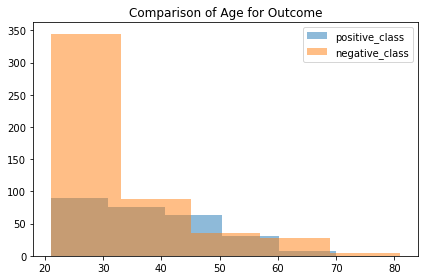

Age
 Ttest_indResult(statistic=6.792688071649956, pvalue=2.2099754606654358e-11)
Difference is statistically significant at alpha = 0.05


In [179]:
for feature in continuous_features:
    compare_features(df, 'Outcome',feature,5,0)

<AxesSubplot:>

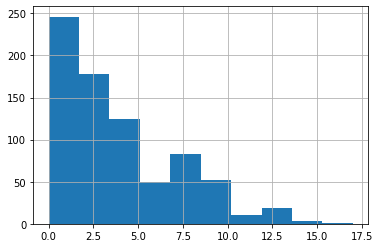

In [21]:
df['Pregnancies'].hist()

<AxesSubplot:>

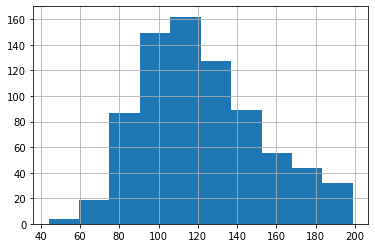

In [20]:
df['Glucose'].hist()

## 2c. Discretize Features

We need to pre-process the data before putting it into the Bayesian Network. 

In [11]:
continuous_df = df.copy()

In [12]:
continuous_features = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age']

For each continous feature, discretize into bins. Try 3 bins, but if non-unique edges put into 2 bins. 

In [53]:
for feature in continuous_features: 
    try:
        df[feature]=pd.qcut(df[feature],3,labels=["1","2","3"])
    except: 
        df[feature]=pd.qcut(df[feature],2,labels=["1","2"])

In [54]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,3,3,2,3,3,2,3,3,1
1,1,1,1,2,1,1,2,2,0
2,3,3,1,2,2,1,3,2,1
3,1,1,1,1,2,1,1,1,0
4,1,3,1,3,2,3,3,2,1


## 2d. Training & Test Split

Training Data will be 70%, testing data will be 30%. This split is done in the function `split_and_sample`.  

In [39]:
X_train, X_over, X_test, y_train, y_over, y_test = split_and_sample(df, continuous_features)
print(f"Training: {y_train.sum() / len(y_train)}")
print(f"Testing: {y_test.sum() / len(y_test)}")
print(f"Balanced Training: {y_over.sum() / len(y_over)}")

Training: 0.33891992551210426
Testing: 0.3722943722943723
Balanced Training: 0.5


# 3. Bayesian Network

## 3a. Construct Networks

In [25]:
no_dependency_model = BayesianNetwork([('Pregnancies','Outcome'),
                         ('SkinThickness','Outcome'),
                         ('BMI','Outcome'),
                         ('Age','Outcome'),
                         ('DiabetesPedigreeFunction','Outcome'), 
                         ('BloodPressure','Outcome'), 
                         ('Insulin','Outcome'), 
                         ('Glucose','Outcome')
                        ])

In [26]:
pregnancy_hierarchical_model = BayesianNetwork([('Pregnancies', 'SkinThickness'), 
                          ('Pregnancies','BMI'), 
                          ('SkinThickness','Outcome'),
                         ('BMI','Outcome'),
                         ('Age','Outcome'),
                         ('DiabetesPedigreeFunction','Outcome'), 
                         ('BloodPressure','Outcome'), 
                         ('Insulin','Outcome'), 
                         ('Glucose','Outcome')
                        ])

In [ ]:
outcome_hierarchical_model = BayesianNetwork([('Pregnancies', 'Outcome'), 
                         ('BMI','Outcome'),
                         ('Age','Outcome'),
                         ('DiabetesPedigreeFunction','Outcome'), 
                         ('BloodPressure','Outcome'), 
                         ('SkinThickness','Outcome'),
                         ('Outcome','Insulin'), 
                         ('Outcome','Glucose')
                        ])

In [27]:
hierarchical_model = BayesianNetwork([('Pregnancies', 'SkinThickness'), 
                          ('Pregnancies','BMI'), 
                          ('SkinThickness','Outcome'),
                         ('BMI','Outcome'),
                         ('Age','Outcome'),
                         ('DiabetesPedigreeFunction','Outcome'), 
                         ('BloodPressure','Outcome'), 
                         ('Outcome','Insulin'), 
                         ('Outcome','Glucose')
                        ])

In [29]:
bayesian_model_list = [no_dependency_model, hierarchical_model, outcome_hierarchical_model, pregnancy_hierarchical_model]
bayesian_model_list_names = ['No Dependency Model', 'Hierarchical Model', 'Outcome Hierarchical Model', 'Pregnancy Hierarchical Model']
bayesian_dict = dict(zip(bayesian_model_list_names, bayesian_model_list))

## 3b. Plot Bayesian Networks 

No Dependency Model


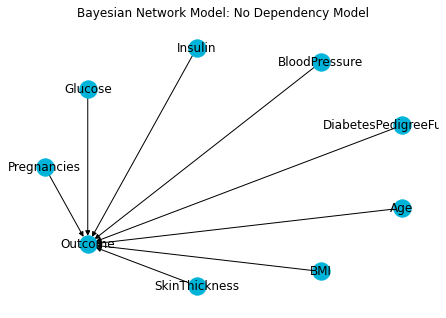

Hierarchical Model


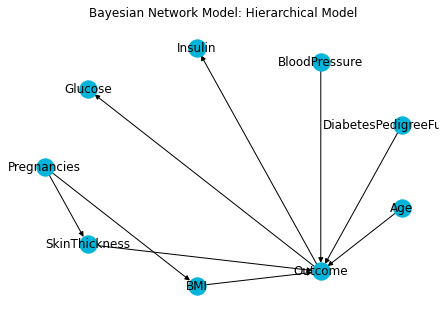

Outcome Hierarchical Model


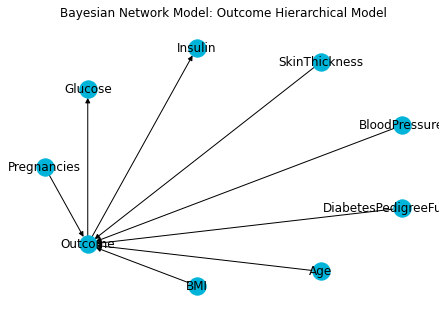

Pregnancy Hierarchical Model


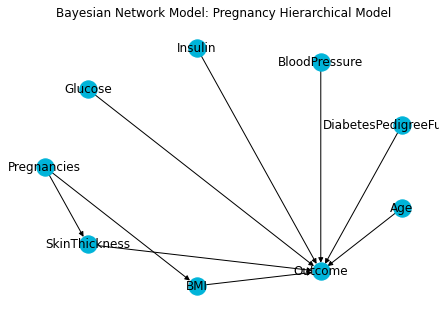

In [30]:
for key in bayesian_dict.keys():
    print(key)
    plot_network(bayesian_dict[key],key)

## 3c. Bayesian Network Training and Evaluation

In [194]:
bayesian_dict

{'No Dependency Model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7f951266c280>,
 'Hierarchical Model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7f94f3387a60>,
 'Outcome Hierarchical Model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7f94e06a8640>,
 'Pregnancy Hierarchical Model': <pgmpy.models.BayesianNetwork.BayesianNetwork at 0x7f9514d3fc70>}

In [88]:
results_dict = {}
sample_types = ['normal','over']
for key in bayesian_dict.keys():
    for sample in sample_types: 
        train_test_network(df,results_dict, continuous_features, bayesian_dict[key],key,sample)

Splitting Data
Fitting Model
Evaluating test


100%|██████████| 219/219 [01:43<00:00,  2.12it/s]


Evaluating train


100%|██████████| 478/478 [03:14<00:00,  2.46it/s]


Add Results to dict

    No Dependency Model: normal 
 
    Train: 

    ROC: 0.9992502624081572  F1: 0.9736842105263158
    Test: 
    ROC: 0.639457256805965  F1: 0.31111111111111106
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 213/213 [01:25<00:00,  2.50it/s]


Evaluating train


100%|██████████| 492/492 [03:24<00:00,  2.41it/s]


Add Results to dict

    No Dependency Model: over 
 
    Train: 

    ROC: 0.9995056449432125  F1: 0.9869375907111756
    Test: 
    ROC: 0.6485470085470086  F1: 0.2826086956521739
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 224/224 [00:02<00:00, 100.62it/s]


Evaluating train


100%|██████████| 474/474 [00:04<00:00, 102.79it/s]


Add Results to dict

    Hierarchical Model: normal 
 
    Train: 

    ROC: 0.9419990899438798  F1: 0.7968337730870712
    Test: 
    ROC: 0.6695994637171108  F1: 0.5508982035928144
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 218/218 [00:01<00:00, 116.04it/s]


Evaluating train


100%|██████████| 486/486 [00:06<00:00, 80.79it/s] 


Add Results to dict

    Hierarchical Model: over 
 
    Train: 

    ROC: 0.9486941503099173  F1: 0.8765603328710124
    Test: 
    ROC: 0.6865027678280691  F1: 0.5930232558139534
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 220/220 [00:06<00:00, 31.44it/s]


Evaluating train


100%|██████████| 483/483 [00:17<00:00, 26.89it/s]


Add Results to dict

    Outcome Hierarchical Model: normal 
 
    Train: 

    ROC: 0.9777190213101814  F1: 0.8587257617728532
    Test: 
    ROC: 0.6208898239052517  F1: 0.5207100591715976
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 215/215 [00:06<00:00, 33.03it/s]


Evaluating train


100%|██████████| 479/479 [00:14<00:00, 32.24it/s]


Add Results to dict

    Outcome Hierarchical Model: over 
 
    Train: 

    ROC: 0.9756861870788743  F1: 0.9150684931506848
    Test: 
    ROC: 0.6355762824783477  F1: 0.5568181818181818
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 221/221 [00:25<00:00,  8.67it/s]


Evaluating train


100%|██████████| 473/473 [00:55<00:00,  8.50it/s]


Add Results to dict

    Pregnancy Hierarchical Model: normal 
 
    Train: 

    ROC: 0.9942254082039028  F1: 0.9217391304347826
    Test: 
    ROC: 0.6538713373710918  F1: 0.3047619047619048
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 217/217 [00:22<00:00,  9.47it/s]


Evaluating train


100%|██████████| 483/483 [01:08<00:00,  7.05it/s]


Add Results to dict

    Pregnancy Hierarchical Model: over 
 
    Train: 

    ROC: 0.995021551004043  F1: 0.9566473988439307
    Test: 
    ROC: 0.6383454208129533  F1: 0.2626262626262626
    


## 3d. Explore Conditional Probability Distributions and Node Cardinality

In [89]:
for key in bayesian_dict.keys():
    print(key)
    print(bayesian_dict[key].get_cpds()) 
    for feature in continuous_features: 
        print(f"Node: {feature}: {bayesian_dict[key].get_cardinality(feature)}")

No Dependency Model
[<TabularCPD representing P(Pregnancies:3) at 0x7f807ae46c40>, <TabularCPD representing P(Outcome:2 | Age:3, BMI:3, BloodPressure:3, DiabetesPedigreeFunction:3, Glucose:3, Insulin:3, Pregnancies:3, SkinThickness:3) at 0x7f807b1e3ac0>, <TabularCPD representing P(SkinThickness:3) at 0x7f807b093190>, <TabularCPD representing P(BMI:3) at 0x7f80c9dec2b0>, <TabularCPD representing P(Age:3) at 0x7f80c9e02850>, <TabularCPD representing P(DiabetesPedigreeFunction:3) at 0x7f80c9110fa0>, <TabularCPD representing P(BloodPressure:3) at 0x7f80c9c91e20>, <TabularCPD representing P(Insulin:3) at 0x7f80c91106a0>, <TabularCPD representing P(Glucose:3) at 0x7f807b1e35b0>]
Node: Pregnancies: 3
Node: Glucose: 3
Node: BloodPressure: 3
Node: SkinThickness: 3
Node: Insulin: 3
Node: BMI: 3
Node: DiabetesPedigreeFunction: 3
Node: Age: 3
Hierarchical Model
[<TabularCPD representing P(Pregnancies:3) at 0x7f80a91c1eb0>, <TabularCPD representing P(SkinThickness:3 | Pregnancies:3) at 0x7f80c9ea18

# 4. Naive Bayes

In [115]:
nb_model = NaiveBayes()
train_test_network(df, results_dict, continuous_features, nb_model, model_name='Naive Bayes',sample_type='normal')
train_test_network(df, results_dict, continuous_features, nb_model, model_name='Naive Bayes',sample_type='over')

Splitting Data
Fitting Model
Evaluating test


100%|██████████| 222/222 [00:04<00:00, 45.20it/s]


Evaluating train


100%|██████████| 476/476 [00:00<00:00, 1115.13it/s]


Add Results to dict

    Naive Bayes: normal 
 
    Train: 

    ROC: 0.7999289926214073  F1: 0.6174142480211081
    Test: 
    ROC: 0.8255036261079773  F1: 0.6744186046511628
    
Splitting Data
Fitting Model
Evaluating test


100%|██████████| 219/219 [00:00<00:00, 924.74it/s]


Evaluating train


100%|██████████| 472/472 [00:00<00:00, 1273.73it/s]


Add Results to dict

    Naive Bayes: over 
 
    Train: 

    ROC: 0.8255604956957714  F1: 0.7637906647807639
    Test: 
    ROC: 0.780441998602376  F1: 0.5775401069518717
    


# 5. Bayesian Inference

## 5a. Variable Elimination (Naive Bayes)

### Infer the Posterior Probability After Observing Evidence (Naive Bayes)

In [90]:
infer = VariableElimination(nb_model)
posterior_p = infer.query(["Outcome"], evidence={"BMI": '1'
                                                 , "DiabetesPedigreeFunction": '1'})
print(posterior_p)

0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.8996 |
+------------+----------------+
| Outcome(1) |         0.1004 |
+------------+----------------+


In [93]:
values = ['1','2','1']
fields = ['Pregnancies','Age','BMI']
evidence_dict = dict(zip(fields,values))
estimate_posterior(nb_model, evidence_dict)


0it [00:00, ?it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.8952 |
+------------+----------------+
| Outcome(1) |         0.1048 |
+------------+----------------+


In [94]:
values = ['2','2','2']
fields = ['Pregnancies','Age','BMI']
evidence_dict = dict(zip(fields,values))
estimate_posterior(nb_model, evidence_dict)





0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:16, ?it/s]
Finding Elimination Order: : : 0it [00:03, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.5234 |
+------------+----------------+
| Outcome(1) |         0.4766 |
+------------+----------------+


In [95]:
values = ['2','2','2']
fields = ['Pregnancies','Age','BMI']
evidence_dict = dict(zip(fields,values))
estimate_posterior(nb_model, evidence_dict)

0it [00:00, ?it/s]n Order: : : 0it [00:00, ?it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.5234 |
+------------+----------------+
| Outcome(1) |         0.4766 |
+------------+----------------+


## 5b. Variable Elimination (Best Performing Bayes Net: Outcome Hierarchical Model)

In [96]:
infer = VariableElimination(outcome_hierarchical_model)
posterior_p = infer.query(["Outcome"], evidence={"BMI": '1'
                                                 , "DiabetesPedigreeFunction": '1'})
print(posterior_p)

Finding Elimination Order: : : 0it [19:30, ?it/s]
Eliminating: Pregnancies: 100%|██████████| 4/4 [00:00<00:00, 277.52it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.6290 |
+------------+----------------+
| Outcome(1) |         0.3710 |
+------------+----------------+


In [97]:
values = ['1','1','1']
fields = ['Pregnancies','Age','BMI']
evidence_dict = dict(zip(fields,values))
estimate_posterior(outcome_hierarchical_model, evidence_dict)

Eliminating: SkinThickness: 100%|██████████| 3/3 [00:00<00:00, 487.97it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.7888 |
+------------+----------------+
| Outcome(1) |         0.2112 |
+------------+----------------+


In [98]:
values = ['2','1','1']
fields = ['Pregnancies','Age','BMI']
evidence_dict = dict(zip(fields,values))
estimate_posterior(outcome_hierarchical_model, evidence_dict)

Eliminating: SkinThickness: 100%|██████████| 3/3 [00:00<00:00, 494.81it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.5837 |
+------------+----------------+
| Outcome(1) |         0.4163 |
+------------+----------------+


In [99]:
values = ['2','2','3']
fields = ['BMI','Age','Glucose']
evidence_dict = dict(zip(fields,values))
estimate_posterior(outcome_hierarchical_model, evidence_dict)

Eliminating: Pregnancies: 100%|██████████| 4/4 [00:00<00:00, 520.69it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.2065 |
+------------+----------------+
| Outcome(1) |         0.7935 |
+------------+----------------+


In [100]:
values = ['1','2','1']
fields = ['BMI','Age','Glucose']
evidence_dict = dict(zip(fields,values))
estimate_posterior(outcome_hierarchical_model, evidence_dict)

Eliminating: Pregnancies: 100%|██████████| 4/4 [00:00<00:00, 479.16it/s]

+------------+----------------+
| Outcome    |   phi(Outcome) |
+============+================+
| Outcome(0) |         0.8369 |
+------------+----------------+
| Outcome(1) |         0.1631 |
+------------+----------------+


# 6. Markov Network 

Now, we will use Markov Networks (non-directed edges)

## 6a. Construct the Markov Network

In [101]:
G = MarkovNetwork()
markov_model = MarkovNetwork([('Pregnancies', 'Outcome'), 
                          ('SkinThickness','Outcome'),
                         ('BMI','Outcome'),
                         ('Age','Outcome'),
                         ('DiabetesPedigreeFunction','Outcome'), 
                         ('BloodPressure','Outcome'), 
                         ('Outcome','Insulin'), 
                         ('Outcome','Glucose')
                        ])

In [102]:
markov_model.get_local_independencies()

(Pregnancies ⟂ SkinThickness, BloodPressure, Glucose, Age, BMI, Insulin, DiabetesPedigreeFunction | Outcome)
(SkinThickness ⟂ Pregnancies, BloodPressure, Glucose, Age, BMI, Insulin, DiabetesPedigreeFunction | Outcome)
(BMI ⟂ SkinThickness, Pregnancies, BloodPressure, Glucose, Age, Insulin, DiabetesPedigreeFunction | Outcome)
(Age ⟂ SkinThickness, Pregnancies, BloodPressure, Glucose, BMI, Insulin, DiabetesPedigreeFunction | Outcome)
(DiabetesPedigreeFunction ⟂ SkinThickness, Pregnancies, BloodPressure, Glucose, Age, BMI, Insulin | Outcome)
(BloodPressure ⟂ SkinThickness, Pregnancies, Glucose, Age, BMI, Insulin, DiabetesPedigreeFunction | Outcome)
(Insulin ⟂ SkinThickness, Pregnancies, BloodPressure, Glucose, Age, BMI, DiabetesPedigreeFunction | Outcome)
(Glucose ⟂ SkinThickness, Pregnancies, BloodPressure, Age, BMI, Insulin, DiabetesPedigreeFunction | Outcome)

## 6b. Convert to a Bayesian Model 

In [103]:
bayesian_model = markov_model.to_bayesian_model()

Finding Elimination Order: : 100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


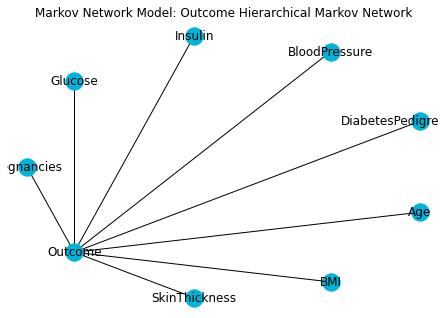

In [106]:
plot_network_markov(markov_model,'Outcome Hierarchical Markov Network')

## 6c. Create Junction Tree 

In [107]:
junction_tree = markov_model.to_junction_tree()

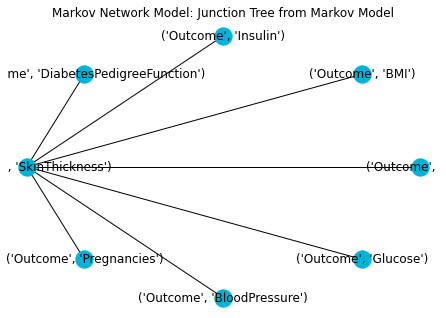

In [108]:
plot_network_markov(junction_tree, 'Junction Tree from Markov Model')

# 7. Inference using Belief Propagation

In [109]:
bp = BeliefPropagation(outcome_hierarchical_model)
bp.calibrate()

In [110]:
bp.map_query(variables=['Outcome'])

Eliminating: DiabetesPedigreeFunction: 100%|██████████| 8/8 [00:00<00:00, 279.56it/s]


{'Outcome': 0}

In [111]:
bp.map_query(variables=['Outcome'], evidence = {'DiabetesPedigreeFunction':'3'})

Eliminating: Insulin: 100%|██████████| 7/7 [00:00<00:00, 643.69it/s]


{'Outcome': 1}

In [112]:
bp.map_query(variables=['Outcome'], evidence = evidence_dict)

Eliminating: DiabetesPedigreeFunction: 100%|██████████| 5/5 [00:00<00:00, 1066.33it/s]


{'Outcome': 0}

In [113]:
bp.get_cliques()

NodeView((('Outcome', 'Glucose'), ('Outcome', 'Insulin'), ('Outcome', 'SkinThickness', 'Pregnancies', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age')))

# 8. Markov Chain Monte Carlo (MCMC)

We will implement Markov Chain Monte Carlo to estimate parameters of a logistic regression model fit to the diabetes data. For this, we will use the original data frame with the continuous features, and not the discretized data frame. 

## 8a. Logistic Regression (for MCMC)

In [18]:
logmodel = LogisticRegression(max_iter=300) 
X_train, X_over, X_test,  y_train, y_over, y_test = split_and_sample(continuous_df, continuous_features)

print("No oversampling")
logmodel.fit(X_train, y_train)
y_pred = logmodel.predict_proba(X_test)
print("Test Data")
print(f"ROC Score: {roc_auc_score(y_test, y_pred[:,1])}")

# train data 
print("Train Data")
y_pred = logmodel.predict_proba(X_train)
print(f"ROC Score: {roc_auc_score(y_train, y_pred[:,1])}")

# with oversampling 
print("With oversampling")
logmodel.fit(X_over, y_over)
y_pred = logmodel.predict_proba(X_test)
print("Test Data")
print(f"ROC Score: {roc_auc_score(y_test, y_pred[:,1])}")

# over data 
print("Train Data (Oversampled)")
y_pred = logmodel.predict_proba(X_over)
print(f"ROC Score: {roc_auc_score(y_over, y_pred[:,1])}")




No oversampling
Test Data
ROC Score: 0.8422338000651254
Train Data
ROC Score: 0.8388974201474201
With oversampling
Test Data
ROC Score: 0.8434549006838163
Train Data (Oversampled)
ROC Score: 0.8273905604338843


In [19]:
X_train['intercept'] = np.ones((len(X_train),1))
X_test['intercept'] = np.ones((len(X_test),1))

In [20]:
smlog = sm.Logit(y_train,X_train) # with intercept
smlog.fit()
smlog.fit().summary()

Optimization terminated successfully.
         Current function value: 0.463734
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.463734
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Outcome   No. Observations:                  537
Model:                          Logit   Df Residuals:                      528
Method:                           MLE   Df Model:                            8
Date:                Sun, 01 May 2022   Pseudo R-squ.:                  0.2799
Time:                        12:07:01   Log-Likelihood:                -249.03
converged:                       True   LL-Null:                       -345.82
Covariance Type:            nonrobust   LLR p-value:                 1.435e-37
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Pregnancies                  0.1373      0.039      3.479      0.001       0.060       0.215
Glucose                      0.0362      0.004      8.135      0.000       0.027       0.045
BloodPressure               -0.0068      0.010     -0.667      0.505      -0.027       0.013
SkinThickness                0.0018      0.012      0.147      0.883      -0.022       0.026
Insulin                     -0.0008      0.001     -0.790      0.430      -0.003       0.001
BMI                          0.0920      0.020      4.495      0.000       0.052       0.132
DiabetesPedigreeFunction     1.2384      0.377      3.283      0.001       0.499       1.978
Age                          0.0127      0.012      1.095      0.273      -0.010       0.035
intercept                   -9.1857      0.974     -9.436      0.000     -11.094      -7.278
============================================================================================
"""

## 8b. Apply MCMC 

This section of the project leveraged an online tutorial for how to implement MCMC on a logistic regression model in Python: <br>
https://github.com/WillKoehrsen/ai-projects/blob/master/markov_chain_monte_carlo/markov_chain_monte_carlo.ipynb <br>

For simplicitly, we will estimate the highest contribution parameter based on the initial logistic regression model, which is `DiabetesPedigreeFunction`, as B1, as well as the `Intercept` (alpha). Future work can expand on this by estimating the other model parameters.

In [21]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# scipy for algorithms
import scipy
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm
import theano.tensor as tt
import scipy
from scipy import optimize

# matplotlib for plotting
import matplotlib.pyplot as plt

In [22]:
mcmc_data = continuous_df['DiabetesPedigreeFunction']
observations = np.array(continuous_df['Outcome'])

In [24]:
N_SAMPLES = 5000
with pm.Model() as diabetes_model:
    # Create the alpha and beta parameters (based on initial regression model)
    alpha = pm.Normal('alpha', mu=-9.1857, tau=0.974, testval=0.0)
    b1 = pm.Normal('b1', mu=1.2384, tau=0.377, testval=0.0)
    
    # Create the probability from the logistic function
    
    p = pm.Deterministic('p', 1. / (1. + tt.exp(b1 * mcmc_data + alpha)))
    
    # Create the bernoulli parameter which uses the observed dat
    observed = pm.Bernoulli('obs', p, observed=observations)   
    
    # Using Metropolis Hastings Sampling
    step = pm.Metropolis()
    
    # Sample from the posterior using the sampling method
    diabetes_trace = pm.sample(N_SAMPLES, step=step);

/var/folders/5b/097q004j6y931y58xbtf2n280000gn/T/ipykernel_59242/2678411567.py:18: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  diabetes_trace = pm.sample(N_SAMPLES, step=step);
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [b1]
>Metropolis: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 20 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [25]:
# Extract the alpha and beta samples
alpha_samples = diabetes_trace["alpha"][5000:, None]
beta_samples = diabetes_trace["b1"][5000:, None]

In [26]:
# Time values for probability prediction
ped_est = np.linspace(mcmc_data.min()- 0.5, mcmc_data.max() + 0.5)[:, None]

# Take most likely parameters to be mean values
alpha_est = alpha_samples.mean()
beta_est = beta_samples.mean()

# Probability at each time using mean values of alpha and beta
diabetes_est = logistic(ped_est, beta=beta_est, alpha=alpha_est)

print(f"Alpha Estimate: {alpha_est} \b Beta Estimate {beta_est}")

Alpha Estimate: 0.945640388832786 Beta Estimate -0.7871913186662199


{'whiskers': [<matplotlib.lines.Line2D at 0x7fb05985afa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fb0598530a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fb05985ab20>],
 'medians': [<matplotlib.lines.Line2D at 0x7fb059853b20>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fb06dd57490>],
 'means': []}

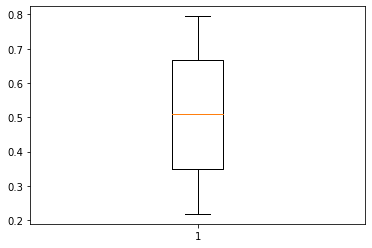

In [27]:
plt.boxplot(diabetes_est)

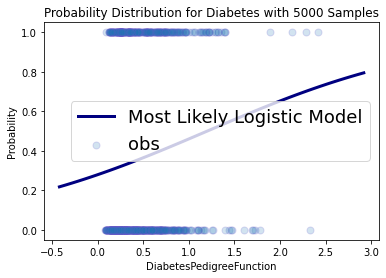

In [28]:
plt.plot(ped_est, diabetes_est, color = 'navy', 
         lw=3, label="Most Likely Logistic Model")
plt.scatter(mcmc_data, observations, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title(f'Probability Distribution for Diabetes with {N_SAMPLES} Samples');
plt.legend(prop={'size':18})
plt.ylabel('Probability')
plt.xlabel('DiabetesPedigreeFunction');

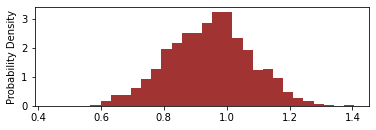

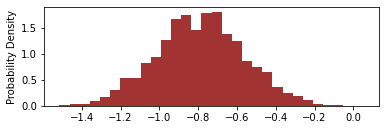

In [31]:
sample_list = [alpha_samples, beta_samples]
for sample in sample_list: 
    plot_samples(sample)